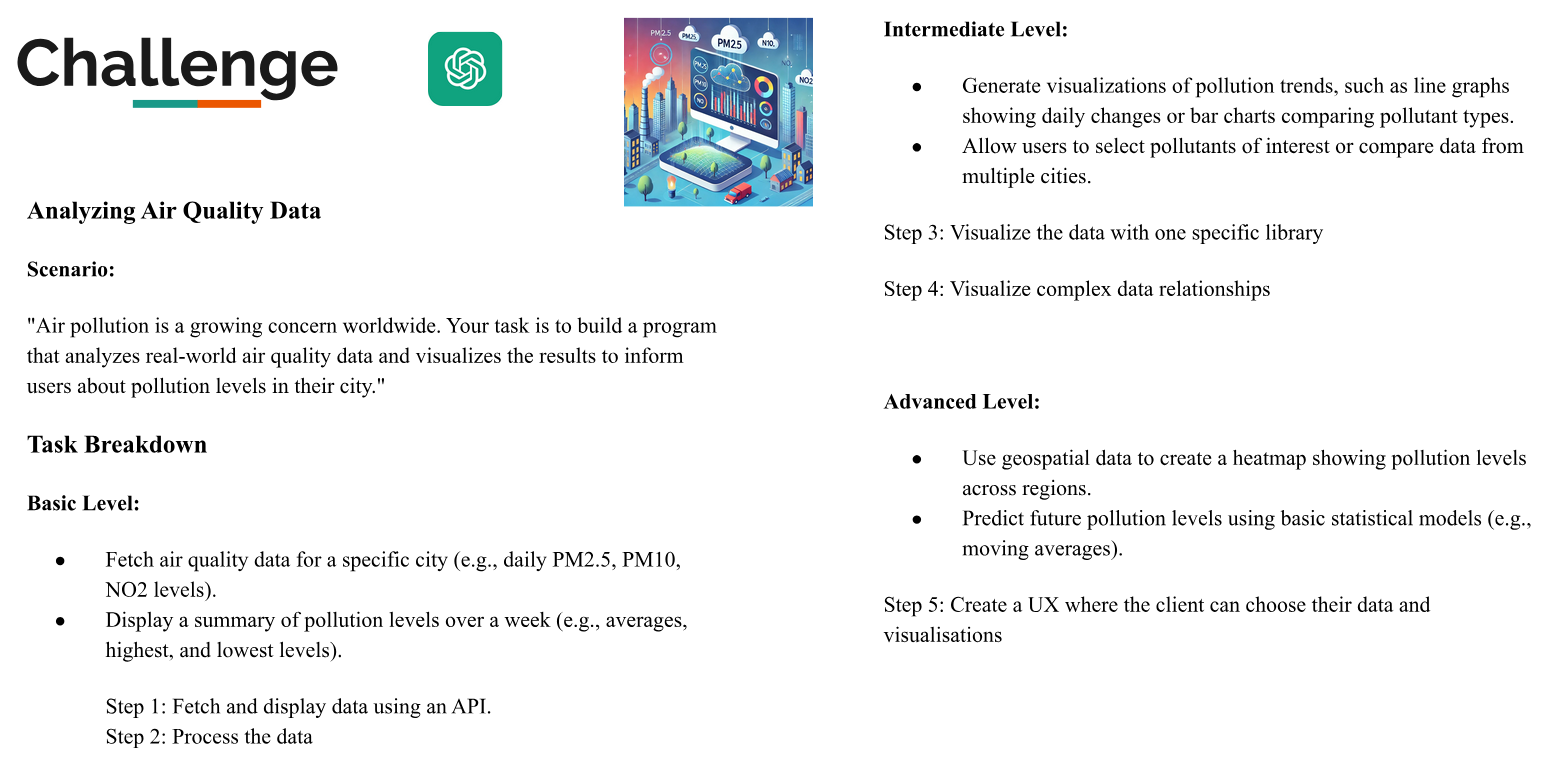

https://open-meteo.com/en/docs/air-quality-api#location_mode=csv_coordinates&past_days=7&forecast_days=7

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import requests

In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

In [30]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache/.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [31]:
def get_weather_data(latitude: list | float, longitude: list | float):
	# Make sure all required weather variables are listed here
	# The order of variables in hourly or daily is important to assign them correctly below
	url = "https://air-quality-api.open-meteo.com/v1/air-quality"
	params = {
		"latitude": latitude,
		"longitude": longitude,
		"hourly": ["pm10", "pm2_5", "nitrogen_dioxide"],
		"timeformat": "unixtime",
		"past_days": 7,
		"forecast_days": 0
	}
	responses = openmeteo.weather_api(url, params=params)
	return responses  # returns a list of responses

In [32]:
from openmeteo_sdk.WeatherApiResponse import WeatherApiResponse
def print_weather_data_title(response: WeatherApiResponse):
    # Process first location. Add a for-loop for multiple locations or weather models
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")
    print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
    print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

In [36]:
def create_weather_dataframe(response: WeatherApiResponse):
	# Process hourly data. The order of variables needs to be the same as requested.
	hourly = response.Hourly()
	hourly_pm10 = hourly.Variables(0).ValuesAsNumpy()
	hourly_pm2_5 = hourly.Variables(1).ValuesAsNumpy()
	hourly_nitrogen_dioxide = hourly.Variables(2).ValuesAsNumpy()

	hourly_data = {"date": pd.date_range(
		start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
		end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
		freq = pd.Timedelta(seconds = hourly.Interval()),
		inclusive = "left"
	)}

	hourly_data["pm10"] = hourly_pm10
	hourly_data["pm2_5"] = hourly_pm2_5
	hourly_data["nitrogen_dioxide"] = hourly_nitrogen_dioxide

	hourly_dataframe = pd.DataFrame(data = hourly_data)
	hourly_dataframe.set_index("date", inplace = True)
	#print(hourly_dataframe)
	return hourly_dataframe

In [40]:
responses = get_weather_data(48.8566, 2.3522)
print_weather_data_title(responses[0])
df = create_weather_dataframe(responses[0])

Coordinates 48.900001525878906°N 2.3999996185302734°E
Elevation 36.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


In [41]:
df.describe()

,pm10,pm2_5,nitrogen_dioxide
count,168.000000,168.000000,168.000000
mean,15.707142,12.439286,31.137503
std,11.473430,10.593440,19.675695
min,2.100000,1.600000,3.100000
25%,7.100000,4.700000,15.650000
50%,11.150000,6.850000,29.850000
75%,23.225000,19.700000,44.374999
max,62.799999,57.700001,81.500000


In [ ]:
df.head(50)

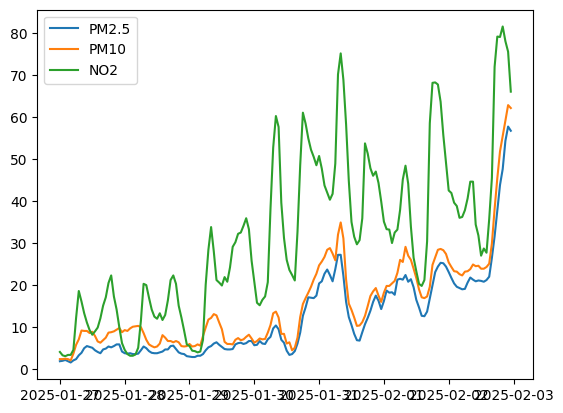

In [45]:
plt.figure()
plt.plot(df.index, df["pm2_5"], label = "PM2.5")
plt.plot(df.index, df["pm10"], label = "PM10")
plt.plot(df.index, df["nitrogen_dioxide"], label = "NO2")
plt.legend()

plt.show()

<Axes: xlabel='date'>

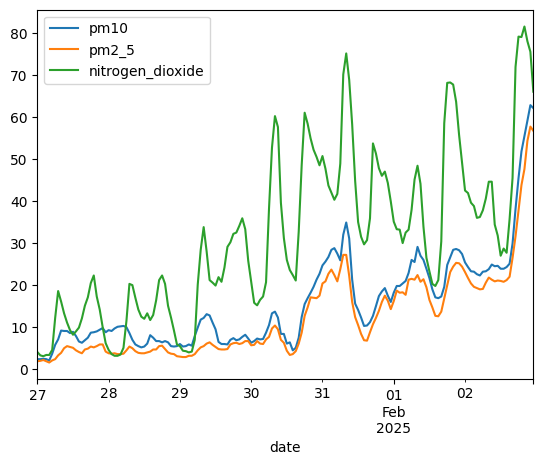

In [47]:
df.plot(y = ["pm10", "pm2_5", "nitrogen_dioxide"])